In [10]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
full_regression_data = pickle.load( open( "full_regression_data.pkl", "rb" ) )

In [85]:
df = full_regression_data

In [86]:
df['log_num_weeks'] = df.num_weeks.apply(np.log)

In [68]:
df.rename(columns={'num_weeks':'log_num_weeks'}, inplace=True)

# analyzing num weeks relationship to ratings

In [69]:
df.groupby('rating').log_num_weeks.mean()

rating
G                2.033120
NC-17            2.202001
Not Yet Rated    1.684546
PG               1.922903
PG-13            1.983267
R                1.835047
Unknown          0.895880
Unrated          1.889241
Name: log_num_weeks, dtype: float64

# Adding a months feature to the df, then dummy for each month

In [87]:
df['release_month'] = df.release_date.apply (lambda row: row.month)

In [71]:
df.release_month.head()

0     6
1    10
2     6
3    11
4     8
Name: release_month, dtype: int64

In [88]:
df.groupby('release_month').log_num_weeks.mean()

release_month
1     1.992990
2     2.022234
3     2.051914
4     2.026930
5     2.083417
6     2.130075
7     2.077903
8     1.938143
9     1.871902
10    1.782442
11    1.607233
12    1.001689
Name: log_num_weeks, dtype: float64

In [89]:
month_dummies = pd.get_dummies(df.release_month)

In [90]:
test = pd.concat([df,month_dummies],axis=1)

In [91]:
test.shape

(8143, 58)

In [95]:
df.columns

Index([u'index', u'title', u'domestic_total', u'runtime', u'rating',
       u'release_date', u'num_weeks', u'weekly_data', u'weekly_gross1',
       u'weekly_gross2', u'weekly_gross3', u'weekly_gross4', u'weekly_gross5',
       u'weekly_gross6', u'weekly_gross7', u'weekly_gross8', u'weekly_gross9',
       u'weekly_gross10', u'weekly_gross11', u'weekly_gross12',
       u'num_theaters1', u'num_theaters2', u'num_theaters3', u'num_theaters4',
       u'num_theaters5', u'num_theaters6', u'num_theaters7', u'num_theaters8',
       u'num_theaters9', u'num_theaters10', u'num_theaters11',
       u'num_theaters12', u'rank1', u'rank2', u'rank3', u'rank4', u'rank5',
       u'rank6', u'rank7', u'rank8', u'rank9', u'rank10', u'rank11', u'rank12',
       u'log_num_weeks', u'release_month'],
      dtype='object')

# accounting for OUTLIERS

after some inspection, i realized that there are some specific types of films stay in theatres for ever! this is unrepresentative of the phenomenon i am intending to model, a different class entirely. 

In [246]:
df_normal = df[df['num_weeks']<=30]

df_long = df[df['num_weeks']>30]

note that:

In [243]:
df_normal[['weekly_gross1','rank1', 'num_theaters1']].mean()

weekly_gross1    8098264.382776
rank1                 32.596819
num_theaters1        928.267597
dtype: float64

In [244]:
df_long[['weekly_gross1','rank1', 'num_theaters1']].mean()

weekly_gross1    173687.726027
rank1                59.214286
num_theaters1         9.486111
dtype: float64

use a plot to demonstrate this. different colors

# theory, there are different types of films, characterized by low budget, low theatres. accounting for low theatre count and high theatre counts== different movie types!

In [247]:
df_hight = df_normal[df_normal.num_theaters1>50]
df_lowt = df_normal[df_normal.num_theaters1<=50]

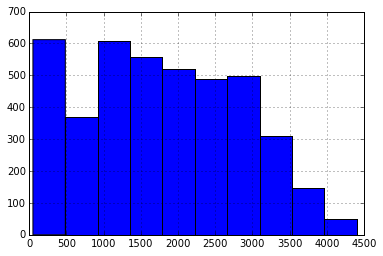

In [248]:
df_hight.num_theaters1.hist()

In [241]:
df_normal[['weekly_gross1','rank1', 'num_theaters1']][df_normal.num_theaters1 <= 50].mean()


weekly_gross1    84873.360342
rank1               61.090714
num_theaters1        6.828113
dtype: float64

In [240]:
df_normal[['weekly_gross1','rank1', 'num_theaters1']][df_normal.num_theaters1 > 50].mean()

weekly_gross1    15613662.956292
rank1                   6.925908
num_theaters1        1783.099664
dtype: float64

# looking into using diffs instead of abs 

In [ ]:
r = df.rank5-df.rank1
g = df.weekly_gross5-df.weekly_gross1
t = df.num_theaters6-df.num_theaters2
y = df.num_weeks
lny = df.log_num_weeks

In [ ]:
plt.scatter(y,m)